In [64]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
import stft
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time import perf_counter
from datetime import datetime

In [2]:
%matplotlib inline

First, let's load some audio

In [3]:
train_audio_name = 'reich'  # what audio we will train on
gen_audio_name = 'reich'  # what audio will be used as a seed for generation
original_audio_list = {'reich': '01-18_Pulses.wav', 'branca': '04-LightField.wav',
                       'schonberg': '2-05_Phantasy_for_Violin_and_Piano.wav',
                       'bach': '26-Variation_25a2Clav_1955.wav'}

In [5]:
rate, data = wavfile.read(original_audio_list[train_audio_name])

Next, we'll compute a spectrogram of a mono signal (obtained by summing the L & R channels) and using the default (cosine) window function

In [6]:
overlap = 4
framelength = 1024

specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)

We're interested in the absolute values of the spectrogram, and we'll log-scale it

In [7]:
log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
print(log_spectrogram.shape)

(513, 56249)


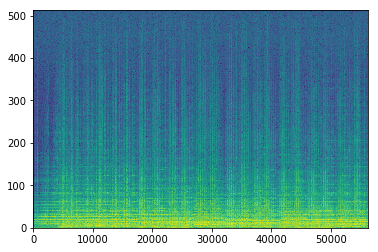

In [8]:
plt.imshow(log_spectrogram, origin='lower', aspect='auto',
           interpolation='nearest')

Now we'll specify for each moment of time `t` which preceding intervals of the form `[t-a,t-b]` we want to use for feature extraction. So if for each interval we have `N` different features, the total amount of different features we'll have is equal to `N * n_intervals`.

We want to have varied information from the audio, so we sample features not for every frame, but each `step_size` frames.

In [9]:
steps = [(-3000, 0), (-2000, 0), (-1000, 0), (-500, 0), (-250, 0), (-100, 0), (-50, 0), (-25, 0), (-10, 0), (-6, 0)]
min_offset = max([-(i[0]) for i in steps])
step_size = 3

In [10]:
min_offset

3000

We want to have the frequency content of an interval as a (vector) feature; but we have too many frequency bins, so we just reduce their number by summation of their content.

In [11]:
freq_avg_step = 9
num_freq_bins_reduced = log_spectrogram.shape[0]//freq_avg_step

freq_avg_step_large = 57
num_freq_bins_reduced_large = log_spectrogram.shape[0]//freq_avg_step_large
print(num_freq_bins_reduced, num_freq_bins_reduced_large)

57 9


Some feature extraction functions

In [12]:
def get_max_amplitude(spgram_slice):
    return np.max(spgram_slice)

In [13]:
def get_min_amplitude(spgram_slice):
    return np.min(spgram_slice)

In [14]:
def get_amplitude_change2(spgram_slice):
    a = np.sum(spgram_slice[:, :spgram_slice.shape[1]//2]) - np.sum(spgram_slice[:, spgram_slice.shape[1]//2:])
    return a / spgram_slice.shape[1]

In [15]:
def get_avg_amplitude(spgram_slice):
    return np.sum(spgram_slice) / spgram_slice.shape[1]  # get average "volume"

In [16]:
def get_max_vol(spgram_slice):
    return np.max(np.sum(spgram_slice,axis=0))

In [17]:
def get_min_vol(spgram_slice):
    return np.min(np.sum(spgram_slice,axis=0))

In [18]:
def get_median_amplitude(spgram_slice):
    return np.median(spgram_slice)

In [19]:
def get_loudest_bins(spgram_slice):
    tmp = np.sum(spgram_slice, axis=1)
    return np.argpartition(tmp, -N_loudest_bins_to_get)[-N_loudest_bins_to_get:]

Now we let's extract the features and the spectral content for each frame;
or we can load a pre-computed feature file and use only the features we want

In [20]:
feature_list = [get_max_amplitude, get_min_amplitude,
                get_avg_amplitude, get_amplitude_change2, get_median_amplitude]
N_loudest_bins_to_get = 10
N_prev_frames = 10

get_slice_freq_bins = True
# get_slice_freq_bins = False  # if true, we take mean of enlarged frequency bin over a slice

freq_bin_feature_list = [get_max_amplitude, get_min_amplitude,
                         get_avg_amplitude]

In [21]:
nfeat = len(feature_list) * len(steps) + num_freq_bins_reduced * N_prev_frames + N_loudest_bins_to_get * len(steps)
if get_slice_freq_bins:
    nfeat += len(steps) * num_freq_bins_reduced
nfeat += len(freq_bin_feature_list) * len(steps) * num_freq_bins_reduced_large
# number of features - we have several scalar features for each slice of audio

print(nfeat)

1560


In [22]:
def get_features_for_frame(log_spgram_slice, scalar_functions, n_features):
    res = np.zeros(n_features)
    counter = 0
    for slicing in steps:
        for s_f in scalar_functions:
            res[counter] = s_f(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += 1
        if N_loudest_bins_to_get > 0:
            res[counter:counter+N_loudest_bins_to_get] = get_loudest_bins(log_spgram_slice[:, min_offset + slicing[0]:min_offset + slicing[1]])
            counter += N_loudest_bins_to_get
    res[counter:counter+num_freq_bins_reduced * N_prev_frames] = log_spgram_slice[::freq_avg_step, -1-N_prev_frames:-1].flatten()
    counter += num_freq_bins_reduced * N_prev_frames
    if get_slice_freq_bins:
        for slicing in steps:
            res[counter:counter+num_freq_bins_reduced] = np.mean(log_spgram_slice[::freq_avg_step, min_offset + slicing[0]:min_offset + slicing[1]],axis=1).flatten()
            counter += num_freq_bins_reduced
    for slicing in steps:
        for s_f in freq_bin_feature_list:
            for i in range(num_freq_bins_reduced_large):
                res[counter] = s_f(log_spgram_slice[freq_avg_step*i:freq_avg_step_large*(i+1),
                                                    min_offset + slicing[0]:min_offset + slicing[1]])
                counter += 1
    return res

In [23]:
def get_feature_names():
    res = []
    for slicing in steps:
        for s_f in feature_list:
            name = s_f.__name__[4:] + '_'
            name += str(slicing[0]) + '_' + str(slicing[1])
            res.append(name)
        for bin_no in range(N_loudest_bins_to_get):
            res.append('loudest_bin_' + str(bin_no))
    for i in range(num_freq_bins_reduced * N_prev_frames):
        res.append('prev_frames_flattened_' + str(i))
    if get_slice_freq_bins:
        for slicing in steps:
            for i in range(num_freq_bins_reduced):
                name = 'freq_binr_' + str(i) + '_mean_'
                name += str(slicing[0]) + '_' + str(slicing[1])
                res.append(name)
    for slicing in steps:
        for s_f in freq_bin_feature_list:
            for i in range(num_freq_bins_reduced_large):
                name = 'freq_binr_' + str(i) + '_' + s_f.__name__[4:] + '_'
                name += str(slicing[0]) + '_' + str(slicing[1])
                res.append(name)
    return res

In [24]:
def process_spectrogram(log_spgram, scalar_functions, n_slices, n_features):
    # features, frequency content - X, Y
    # n_slices - the number of data points
    loc_Y = np.zeros([n_slices, log_spgram.shape[0]])
    loc_X = np.zeros([n_slices, n_features])
    for i in range(n_slices):
        if i%200 == 0:
            print(i)
        loc_Y[i] = log_spgram[:, min_offset + step_size * i]
        loc_X[i, 0:n_features] = get_features_for_frame(log_spgram[:,step_size * i:min_offset
                                                                     + step_size * i], scalar_functions, n_features)
    return [loc_X, loc_Y]

In [53]:
load_from_file = True
features_filename = 'data/reich10k_step32017_9_27_0_features.csv'
target_filename = 'data/reich10k_step3_target.csv'

n_samples = 10000

if not load_from_file:
    start_time = perf_counter()
    X, Y = process_spectrogram(log_spectrogram, feature_list,
                               n_samples, nfeat)
    print(perf_counter() - start_time)
else:
    df_features = pd.read_csv(features_filename)
    df_target = pd.read_csv(target_filename)
    df_features = df_features.drop('timestep', axis=1)
    df_target = df_target.drop('timestep', axis=1)
    
    step_df = df_features.shape[0] // n_samples
    df_features = df_features[::step_df]
    df_target = df_target[::step_df]
    
    feature_cols = get_feature_names()
    df_features = df_features[feature_cols]
    
    X = df_features.values
    Y = df_target.values

If we didn't read the features and target data from a file, we'll write them to disk

In [52]:
if not load_from_file:
    audio_name = train_audio_name + str(n_samples//1000) + 'k_step' + str(step_size) 

    index_array = [min_offset + i * step_size for i in range(n_samples)]

    df = pd.DataFrame({'timestep' : index_array})

    feature_names = get_feature_names()
    for i, f_n in enumerate(feature_names):
        df[f_n] = X[:, i]

    curr_time = datetime.now()
    curr_t_str = str(curr_time.year) + '_' + str(curr_time.month) + '_' + str(curr_time.day) + '_' + str(curr_time.hour)

    df.to_csv('data/' + audio_name + curr_t_str + '_features.csv', index=False)
    
    df = pd.DataFrame({'timestep' : index_array})

    for i in range(log_spectrogram.shape[0]):
        df['freqbin_' + str(i)] = Y[:, i]

    df.to_csv('data/' + audio_name + '_target.csv', index=False)

In [54]:
%reset_selective -f df_features
%reset_selective -f df_target

Next, we scale the features and the target values

In [55]:
feature_scaler_freq = StandardScaler()
X = feature_scaler_freq.fit_transform(X)

freq_Y_mean = np.mean(Y)
freq_Y_std = np.std(Y)

Y = (Y - freq_Y_mean) / freq_Y_std

Then, we train a tree-based predictor for each frequency band

In [91]:
single_predictor = False  # True if we're using a regression model that can output a vector

start_time = perf_counter()

if single_predictor:
#     predictor = DecisionTreeRegressor(max_depth=10)
    predictor = RandomForestRegressor(n_estimators=50, max_depth=6, max_features=500, n_jobs=4)
    predictor.fit(X, Y)
else:
    predictors = []
    for i in range(Y.shape[1]):
        if i%50 == 0:
            print(i)
        predictor = DecisionTreeRegressor(max_depth=10)
        predictor.fit(X, Y[:, i])
        predictors.append(predictor)

print(perf_counter() - start_time)

0
50
100
150
200
250
300
350
400
450
500
4873.432445638001


Let's then try and generate some new audio (frequency amplitude; we'll fill the phase data with uniformly distributed noise) and compare it with the real audio, to assess the performance of our model. First, we'll take a chunk of the audio that hasn't been fed to our model before, to use a starting point.
At some point, the model will only generate audio based on only newly generated audio.
We can also load a different waveform to generate audio based on a model trained on different audio

In [100]:
# rate, data = wavfile.read('results/reich_dt_d10_10k_nominmax.wav')
# overlap = 4
# framelength = 1024

# specgram = stft.spectrogram((data[:, 1] + data[:, 0]), framelength=framelength, overlap=overlap)
# log_spectrogram = np.log(1 + scipy.absolute(specgram))  # X axis - frequency bins, Y axis - time
# # in case we want to use something other as the seed audio, we load a new wav-file here

In [103]:
keep_starting_audio = False  # if False, we cut off the seed audio
gen_start = min_offset + n_samples * step_size
print(gen_start, min_offset)  # the starting point of the seed audio and the length of the seed audio
generate_size = 5000  # how many samples we want to generate
result = np.zeros([log_spectrogram.shape[0], generate_size + min_offset])
result_phase = np.random.rand(log_spectrogram.shape[0], generate_size + min_offset) * 2 * 3.141
feat_arr = np.zeros([1, nfeat])

for i in range(min_offset):
    result[:, i] = log_spectrogram[:, gen_start + i]
start_time = perf_counter()
feature_extr_time = 0
for i in range(generate_size):
    if i%500 == 0:
        print(i)
        
    start_time_f = perf_counter()
    feat_arr[0,:nfeat] = get_features_for_frame(result[:, i:i+min_offset],
                                                feature_list, nfeat)
    feature_extr_time += perf_counter() - start_time_f
    
    if single_predictor:
        result[:, min_offset+i] = predictor.predict(feature_scaler_freq.transform(feat_arr))
        result[:, min_offset+i] *= freq_Y_std  # now we rescale it back
        result[:, min_offset+i] += freq_Y_mean
    else:
        for j in range(Y.shape[1]):
            result[j, min_offset+i] = predictors[j].predict(feature_scaler_freq.transform(feat_arr))
            result[j, min_offset+i] *= freq_Y_std  # now we rescale it back
            result[j, min_offset+i] += freq_Y_mean
total_time = perf_counter() - start_time
print(total_time, ", time spent on feature extraction, %:", feature_extr_time/total_time * 100.)

2000 3000
0
500
1000
1500
2000
2500
3000
3500
4000
4500
538.4197358460005 , time spent on feature extraction, %: 69.59284179733255


In [94]:
print(mean_squared_error(result[:, min_offset:],
                         log_spectrogram[:, gen_start + min_offset:gen_start + min_offset + generate_size]))

2.57866081276


In [104]:
if not keep_starting_audio:  # cut off the original audio
    result = result[:, min_offset:]
    result_phase = result_phase[:, min_offset:]

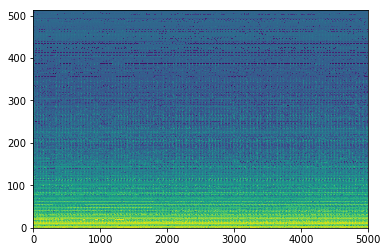

In [105]:
plt.imshow(result, origin='lower', aspect='auto',
           interpolation='nearest')

In [106]:
freq_amplitude = np.exp(result) - 1
result_complex = freq_amplitude * np.exp(1j * result_phase)
audio_dat = stft.ispectrogram(result_complex, framelength=framelength, overlap=overlap)

In [107]:
def write_stereo(a_l, a_r, s_r, name):
    a_s = np.zeros([a_l.shape[0], 2], dtype=np.int16)
    a_s[:, 0] = a_l
    a_s[:, 1] = a_r
    print(a_s.shape)
    wavfile.write(name, s_r, a_s)

In [108]:
output_filename = train_audio_name + '_'
if gen_audio_name != train_audio_name:
    output_filename += gen_audio_name + '_'
if single_predictor:
    output_filename += 's_'
output_filename += 'dt_d10'  #classifier name, params
output_filename += '_' + str(n_samples // 1000) + 'k'

output_filename += '_nominmax'  # additional info
output_filename += '.wav'
print(output_filename)

write_stereo(audio_dat, audio_dat, 44100, 'results/' + output_filename)

reich_dt_d10_10k_nominmaxpt2.wav
(1279744, 2)
